In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from skbio.stats.composition import clr, alr

import os
import sys 

MODULE_PATH = os.path.abspath('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/data-preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit
from interpolation import Interpolation

In [18]:
INPUT_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_no_rarefaction/male_assigned_sample_names.csv'

DF = pd.read_csv(INPUT_FILE, index_col = [0])
DF.index  = DF.index.astype(int)

#interpolate using pchip
interpolator = Interpolation()
INTERPOLATED_DF = interpolator.interpolate_pchip(DF) 

#change to PRC
INTERPOLATED_PRC = INTERPOLATED_DF.div(INTERPOLATED_DF.sum(axis=1), axis=0) + 1e-9

#change to ratio
CLR_DF =  pd.DataFrame(clr(INTERPOLATED_PRC), columns = INTERPOLATED_PRC.columns)

#filter rare bacteria 
processing = MicrobiomeDataPreprocessing()
KEEP_COLUMNS = processing.filter_rare_features(INTERPOLATED_DF, treshold_perc=0.7).columns

FILTERED_CLR_DF = CLR_DF[KEEP_COLUMNS]
FILTERED_COUNT_DF = INTERPOLATED_PRC[KEEP_COLUMNS]


#assign date to index
METADATA_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/raw_data/550_metadata.txt'
metadata = pd.read_csv(METADATA_FILE, sep = '\t')
metadata = metadata[(metadata['body_product'] == 'UBERON:feces') & \
                    (metadata['sex'] == 'male') & \
                    (metadata['mislabeled']==False)].sort_values(by = 'days_since_experiment_start')

dates = pd.date_range(start=metadata['collection_timestamp'].min(), end=metadata['collection_timestamp'].max(), freq='D')

FILTERED_CLR_DF.index = dates

In [27]:
# CREATE TIME-RELATED FEATURES
time_df = pd.DataFrame(FILTERED_CLR_DF.index, columns = ['date'])
time_df['month'], time_df['year'] = FILTERED_CLR_DF.index.month.astype(str), FILTERED_CLR_DF.index.year

def make_new_col(row):
    if row['month'] in (['12', '1', '2']):
        val = 'winter'
    elif row['month'] in (['3', '4', '5']):
        val = 'spring'
    elif row['month'] in (['6', '7', '8']):
        val = 'summer'
    elif row['month'] in (['9', '10', '11']):
        val = 'autumn'
                           
    return val

time_df['SEASON'] = time_df.apply(make_new_col, axis=1)

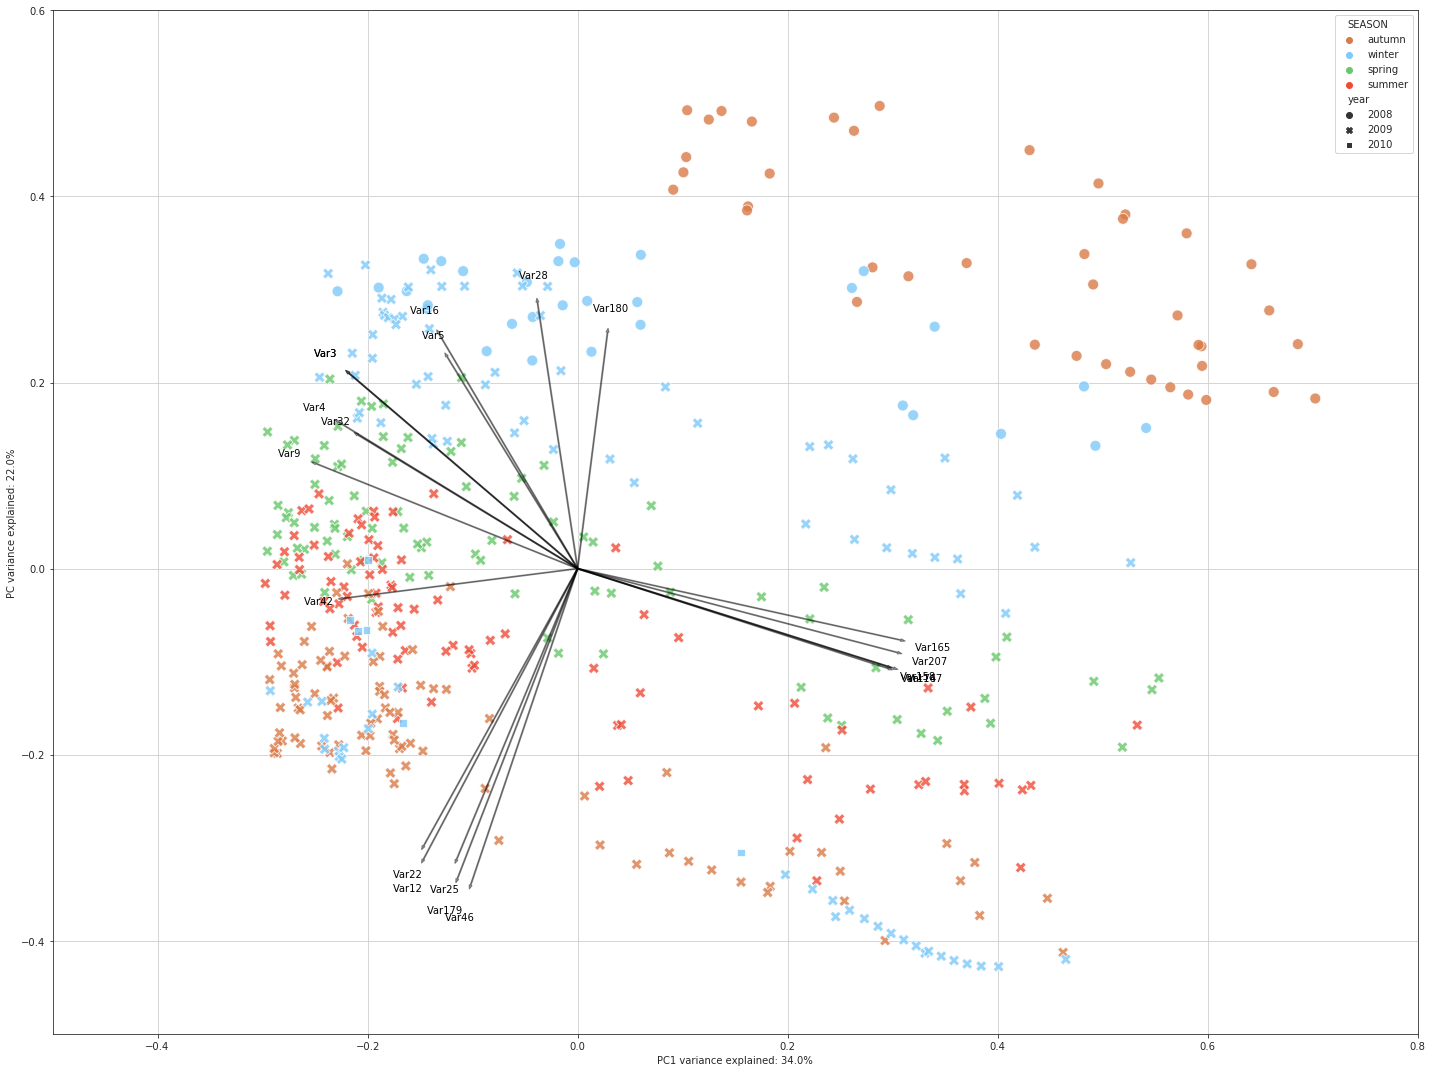

In [30]:
seasonal_colors = ['#D97B48', '#7FCAF9','#68C76A', '#EE4C38']
seasons = ['autumn', 'winter', 'spring', 'summer']            
seasonal_palette = dict(zip(seasons, seasonal_colors))

sns.set_style('ticks')
pca = PCA()
x_new = pca.fit_transform(scaled_X)
score = x_new[:,0:2]
coeff = np.transpose(pca.components_[0:2, :])
hue_variable = time_df['SEASON'] 
style_variable = time_df['year'] 
labels = None#FILTERED_CLR_DF.columns

xs = score[:,0]
ys = score[:,1]
n = 50#len(FILTERED_CLR_DF.columns)
scaled_xs = xs * (1.0/(xs.max() - xs.min()))
scaled_ys = ys * (1.0/(xs.max() - xs.min()))

coeff_df = pd.DataFrame(coeff, columns = ['X', 'Y'])
coeff_df['feature'] = FILTERED_CLR_DF.columns

positive_loadings_X = coeff_df.sort_values(by = ['X']).tail(5).index.tolist()
negative_loadings_X = coeff_df.sort_values(by = ['X']).head(5).index.tolist()

positive_loadings_Y = coeff_df.sort_values(by = ['Y']).tail(5).index.tolist()
negative_loadings_Y = coeff_df.sort_values(by = ['Y']).head(5).index.tolist()

best_loadings = positive_loadings_X + (negative_loadings_X) + positive_loadings_Y +  negative_loadings_Y

fig = plt.figure(figsize=(20, 15))
sns.scatterplot(x = scaled_xs,
                y = scaled_ys,
                alpha = .8,
                edgecolor = 'white',
                hue = hue_variable,
                style=style_variable,
                s=120,
               palette = seasonal_colors)

for i in best_loadings:
    plt.arrow(0, 0, coeff[i,0]*2, coeff[i,1]*2,  alpha = 0.4, color='k')
    if labels is None:
        plt.text(coeff[i,0]*2.2, coeff[i,1]*2.2, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
    #else:
        #plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize = 12)

plt.xlim(-0.5,0.8)
plt.ylim(-0.5,0.6)
plt.xlabel("PC1 variance explained: {}%".format(np.round(pca.explained_variance_[0]), 2))
plt.ylabel("PC variance explained: {}%".format(np.round(pca.explained_variance_[1]), 2))
plt.grid()
plt.tight_layout()
plt.savefig('PCA_MALE_OTU.png')